In [17]:
# -*- coding: utf-8 -*-
"""
@author: martin.bachmann@dlr.de
"""


import numpy as np

from osgeo import gdal
from gdalconst import *

import scipy as scipy
from scipy import linalg, optimize  

from scipy.optimize import curve_fit

from scipy import signal

# for the majority filter we need:
from scipy.ndimage.filters import generic_filter
from scipy.stats import mode


import sys
from sys import stdout

import pickle

import time
import pandas as pd
import spectral.io.envi as envi

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.model_selection import cross_val_predict, train_test_split 
from sklearn.linear_model import LinearRegression



import matplotlib.pyplot as plt
import matplotlib.collections as collections

import seaborn as sns

from scipy.signal import savgol_filter


In [18]:
print("Parts of this code is based on the highly recommended blog:")
print("https://towardsdatascience.com")
print("")   

Parts of this code is based on the highly recommended blog:
https://towardsdatascience.com



In [80]:
# when using the single speclib:
#spectral_lib_path = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/speclib_at_avris_res.slb.hdr"

# when using the combination of 2 soil measurments:
spectral_lib_path = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/both_speclibs_combined_avirisRES.slb.hdr"




lib_in = envi.open(spectral_lib_path)
    
s_spec = lib_in.spectra
s_names = lib_in.names
s_nspec = s_spec.shape[0]
s_nbnds = s_spec.shape[1]

wavel_in = np.asarray(lib_in.bands.centers)




# and get the "lab" references for this:

# when using the single speclib:
#water = np.asarray([0., 1,2,3,6,9,12,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,120,130,140,150,160,170])


# in case of the 2 combined soil measurements
water = np.asarray([0., 1,2,3,6,9,12,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,120,130,140,150,160,170, 0,1,2,3,4,5,6,7,9,11,13,15,17,18,21,23,25,27,29,31])


In [69]:

gdalinstalled = 1

if gdalinstalled == 0:
    #myfile_in = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/cube_from_fieldspec_noisy.npy"

    #myfile_in = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/cube_from_fieldspec.npy"
    
    myfile_in = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/aviris_subset.npy"
  
    img_data = np.load(myfile_in)
    dummy = img_data.shape
    nbnds =  dummy[0]      
    nlines = dummy[1]
    ncols  = dummy[2]
    
if gdalinstalled == 1:        
    # OPEN THE IMAGE
    image_path = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/aviris_subset.bsq"        # the "real" image

    #image_path = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/cube_from_fieldspec.bsq"      # perfect simulated reference consisting of field spectra
    #image_path = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/cube_from_fieldspec_noisy.bsq" # plus some noise added (normal dist., 0 mean, stdev 10 (of 10.000))
                                                                    #  => max. 2% for low reflectance wavelengths


    ds_in = gdal.Open(image_path)
    print("[I] Loading the image to memory...")
    img_data = ds_in.ReadAsArray(0, 0, ds_in.RasterXSize, ds_in.RasterYSize)
    ncols  = ds_in.RasterXSize
    nlines = ds_in.RasterYSize
    nbnds =  ds_in.RasterCount 

[I] Loading the image to memory...


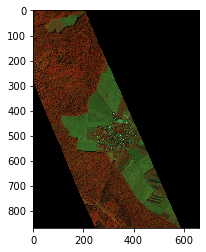

In [70]:
# just for fun: plot bands 10,40, 140

dummy = np.zeros((nlines, ncols, 3), dtype=np.float32)
dummy[:,:,2] = img_data[10,:,:] / np.max(img_data[10,:,:])
dummy[:,:,1] = img_data[40,:,:] / np.max(img_data[40,:,:])
dummy[:,:,0] = img_data[140,:,:] / np.max(img_data[140,:,:])

plt.imshow(dummy, interpolation='nearest')
plt.show()

In [71]:
print("Image dimension", img_data.shape)
print(nbnds)
print(nlines)
print(ncols)

Image dimension (265, 869, 664)
265
869
664


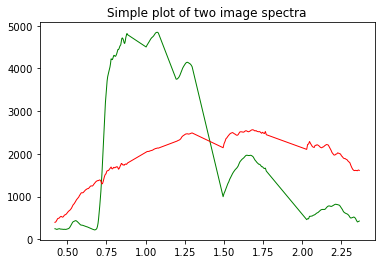

In [72]:
# and plot a spectrum - check if it's the AVIRIS or the synthetic b

if nlines > 100:                    # real aviris data
    dummy1 = img_data[:,9,9]
    dummy2 = img_data[:,400,300]
else:                               # the synthetic example 
    dummy1 = img_data[:,9,9]
    dummy2 = img_data[:,2,2]

plt.figure()
plt.plot(wavel_in, dummy1, color='green', linewidth=1)
plt.plot(wavel_in, dummy2, color='red', linewidth=1)
plt.title('Simple plot of two image spectra')
plt.show()


In [73]:
# initialize output:

img_pred = np.zeros((nlines,ncols))

In [74]:
# PLS with optimized number of components

def optimise_pls_cv(X, y, n_comp, plot_components=True):

    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''

    mse = []
    component = np.arange(1, n_comp)

    for i in component:
        pls = PLSRegression(n_components=i)

        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)

        mse.append(mean_squared_error(y, y_cv))

        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")

    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)

        plt.show()

    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)

    # Fit to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)

    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Water')
        plt.ylabel('Measured $^{\circ}$Water')

        plt.show()

    return pls_opt

17% completed
Suggested number of components:  3



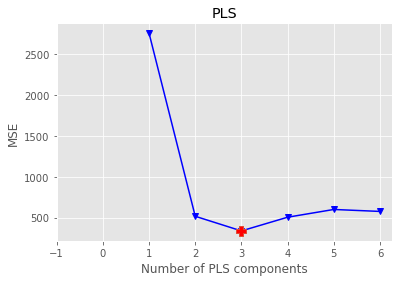

R2 calib: 0.928
R2 CV: 0.848
MSE calib: 159.815
MSE CV: 337.393


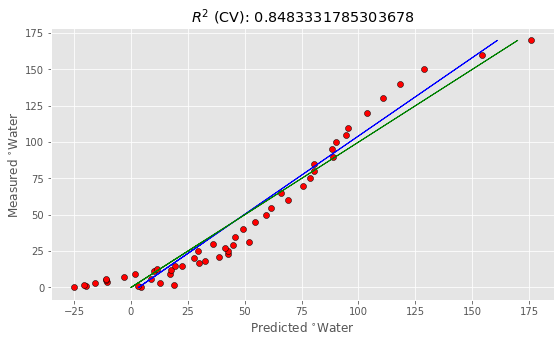

In [87]:
### now calibrating the PLS model
my_model = optimise_pls_cv(s_spec,water, 7, plot_components=True) #7

In [53]:
### and apply it to the image

# to do it without loops, reshape the image to a 2D vector:
img_as_vector = img_data.reshape(265, (nlines*ncols))

img_as_vector = img_as_vector.T

img_pred_vector = img_pred.reshape(nlines*ncols)

# now we can predict the water easily ;)
waterPLS_img = my_model.predict(img_as_vector)

# and reshape the result to an image again:
waterPLS_img = waterPLS_img.reshape(nlines, ncols)

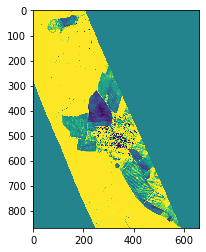

In [55]:
plt.imshow(waterPLS_img, interpolation='nearest', vmin=0, vmax=160) # vmin / vmax is adjusted to image
plt.show()

In [56]:
# store the PLS model within a pickle object to disk:

# store it:
pickle.dump(my_model, open( "C:/Users/bachma_m/Documents/__Jena_2022/PLS_model_3.pkl", "wb" ))
print(my_model)


# destroy it:
my_model = 1
print(my_model)


# and re-load it:
my_model = pickle.load(open("C:/Users/bachma_m/Documents/__Jena_2022/PLS_model_3.pkl", "rb"))
print(my_model)


PLSRegression(n_components=3)
1
PLSRegression(n_components=3)


In [57]:
# now save the image...
format = "ENVI"
driver = gdal.GetDriverByName(format)
outname = image_path + "_watercontent333.bsq"
   
nbnds = 1
mybandnames = "{Soil Water Content}"
print("[I] Writing output to file", outname)
out_rms = driver.Create(outname, ncols, nlines, nbnds, gdal.GDT_Float64) #64 is correct
out_rms.SetMetadataItem("band names", mybandnames)

dummy =  waterPLS_img.astype(np.float64)        
out_rms.GetRasterBand(1).WriteArray(dummy)

[I] Writing output to file C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/aviris_subset.bsq_watercontent333.bsq


0

67% completed
Suggested number of components:  20



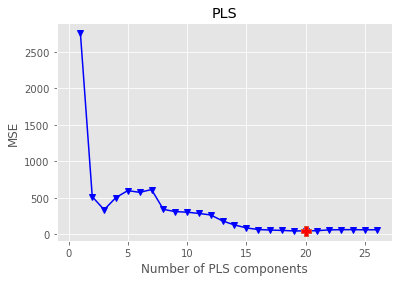

R2 calib: 1.000
R2 CV: 0.979
MSE calib: 0.354
MSE CV: 47.459


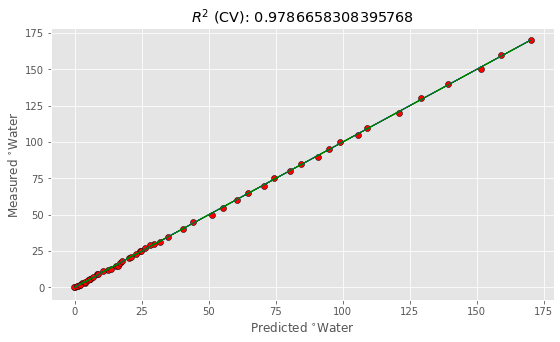

In [59]:
# now let's overfit the model:
overfit_model = optimise_pls_cv(s_spec,water, 27, plot_components=True) 

In [60]:
### and apply it to the image

waterPLS_overfit = overfit_model.predict(img_as_vector)

# and reshape the result to an image again:
waterPLS_overfit = waterPLS_overfit.reshape(nlines, ncols)

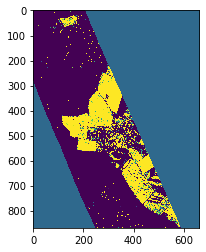

In [61]:
plt.imshow(waterPLS_overfit, interpolation='nearest', vmin=0, vmax=160) # vmin / vmax is adjusted to image
plt.show()

s_nsmi, directly
R2 : -0.9307604300753789
Mean Absolute Error: 45.556636247151175
Root Mean Squared Error: 65.53701210508584
Mean Squared Error: 4295.099955662168

s_ninsol, directly
R2 : -0.934431061589956
Mean Absolute Error: 45.62497723475819
Root Mean Squared Error: 65.59927979807478
Mean Squared Error: 4303.265510026102


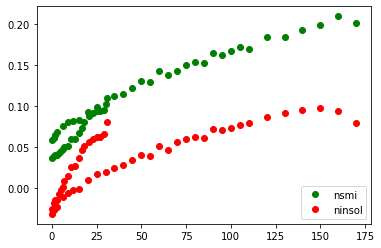

In [81]:
#####################################################
# now just for a fun comparison using some indices:

# see e.g., the following paper and references within:
# https://www.mdpi.com/2072-4292/7/3/3184/htm

#NSMI:   1.800 - 2.120 / 1.800 + 2.120
#NINSOL: 2.080 - 2.230 / 2.080 + 2.230

s_nsmi   = (s_spec[:,207] - s_spec[:,237]) / (s_spec[:,207] + s_spec[:,237])
#s_ninsol = (s_spec[:,217] - s_spec[:,242]) / (s_spec[:,217] + s_spec[:,242])   
s_ninsol = (s_spec[:,242] - s_spec[:,217]) / (s_spec[:,242] + s_spec[:,217])   

print('s_nsmi, directly')
print('R2 :',r2_score(water, s_nsmi))
print('Mean Absolute Error:', mean_absolute_error(water, s_nsmi))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(water, s_nsmi)) )
print('Mean Squared Error:', mean_squared_error(water, s_nsmi))  

print()
print('s_ninsol, directly')
print('R2 :',r2_score(water, s_ninsol))
print('Mean Absolute Error:', mean_absolute_error(water, s_ninsol))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(water, s_ninsol)) )
print('Mean Squared Error:', mean_squared_error(water, s_ninsol))  

plt.figure()
plt.plot(water, s_nsmi,  'ko', color='green', linewidth=1, label="nsmi")
plt.plot(water, s_ninsol,'ko', color='red', linewidth=1, label="ninsol")
plt.legend(loc="lower right")
plt.show()


In [82]:
# next we start the linear model:
mylin_nsmi = LinearRegression(fit_intercept=True)
mylin_ninsol = LinearRegression(fit_intercept=True)

# and do the fitting...
mylin_nsmi.fit(s_nsmi.reshape(-1,1), water)
mylin_ninsol.fit(s_ninsol.reshape(-1,1), water)

# now the predicted water
water_linpred_nsmi   = mylin_nsmi.predict(s_nsmi.reshape(-1,1))
water_linpred_ninsol = mylin_ninsol.predict(s_ninsol.reshape(-1,1))

print('nsmi, linear regression')
print('  Intercept : ',mylin_nsmi.intercept_)
print('  Gain coeff: ',mylin_nsmi.coef_)
print('R2 :',r2_score(water, water_linpred_nsmi))
print('Mean Absolute Error:', mean_absolute_error(water, water_linpred_nsmi))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(water, water_linpred_nsmi)) )
print('Mean Squared Error:', mean_squared_error(water, water_linpred_nsmi))  
# and do the 10-fold cross-validation
water_lin_crossval_nsmi = cross_val_predict(mylin_nsmi, s_nsmi.reshape(-1,1), water, cv=10) # cross-val
mse_lin_crossval_nsmi = mean_squared_error(water, water_lin_crossval_nsmi) # mean error for cross-val
print('MSE cross-val: %5.3f' % mse_lin_crossval_nsmi) 
print()

print('ninsol, linear regression')
print('  Intercept : ',mylin_ninsol.intercept_)
print('  Gain coeff: ',mylin_ninsol.coef_)
print('R2 :',r2_score(water, water_linpred_ninsol))
print('Mean Absolute Error:', mean_absolute_error(water, water_linpred_ninsol))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(water, water_linpred_ninsol)) )
print('Mean Squared Error:', mean_squared_error(water, water_linpred_ninsol))  
# and do the 10-fold cross-validation
water_lin_crossval_ninsol = cross_val_predict(mylin_ninsol, s_ninsol.reshape(-1,1), water, cv=10) # cross-val
mse_lin_crossval_ninsol = mean_squared_error(water, water_lin_crossval_ninsol) # mean error for cross-val
print('MSE cross-val: %5.3f' % mse_lin_crossval_ninsol) 



nsmi, linear regression
  Intercept :  -51.549963936911084
  Gain coeff:  [905.3577749]
R2 : 0.9244040249813551
Mean Absolute Error: 11.126047747729395
Root Mean Squared Error: 12.96796349253222
Mean Squared Error: 168.16807714364845
MSE cross-val: 310.678

ninsol, linear regression
  Intercept :  9.25056732264381
  Gain coeff:  [1028.52211227]
R2 : 0.6792738763462055
Mean Absolute Error: 19.136414823746453
Root Mean Squared Error: 26.71096698037418
Mean Squared Error: 713.4757570266398
MSE cross-val: 1123.937


In [84]:
### and apply it to the image

# avoid idvision by zero error messages:
np.seterr(divide='ignore', invalid='ignore')

img_nsmi = (img_data[207,:,:] - img_data[227,:,:]) / (img_data[207,:,:] + img_data[227,:,:]) 
img_ninsol = (img_data[242,:,:] - img_data[217,:,:]) / (img_data[242,:,:] + img_data[217,:,:]) 


# and then assuming a linear model behind:
img_nsmi_cal   = img_nsmi * mylin_nsmi.coef_+ mylin_nsmi.intercept_
img_ninsol_cal = img_ninsol * mylin_ninsol.coef_+ mylin_ninsol.intercept_


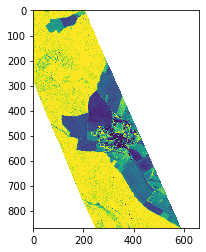

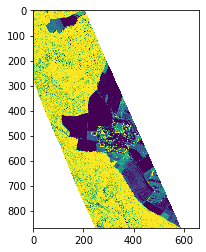

In [85]:
plt.imshow(img_nsmi, interpolation='nearest', vmin=0, vmax=0.4)
plt.show()

plt.imshow(img_ninsol, interpolation='nearest', vmin=0, vmax=0.15)
plt.show()


In [ ]:
# now open the synthetic perfect reference:

if gdalinstalled == 0:
    myfile_refin = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/cube_from_fieldspec_REFWATER.npy"
    ref_data = np.load(myfile_refin)

    
if gdalinstalled == 1:        
    # now open the synthetic perfect reference:
    image_path = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/cube_from_fieldspec_REFWATER.bsq"   #perfect reference


    ref_in = gdal.Open(image_path)
    print("[I] Loading the image to memory...")
    ref_data = ref_in.ReadAsArray(0, 0, ds_in.RasterXSize, ds_in.RasterYSize)

In [ ]:
print("===============================================================")
print("The following cell is only meaningful for the synthetic example")
print("        but not for the real-world AVIRIS data  ")

In [ ]:
# as we likely have NANs in the indices... mask them out
mask = ~np.isnan(waterPLS_img) & ~np.isnan(ref_data)

print("In the following:")

print("      R2 : scipy R2 score, NOT identical with Pearson R^2 !")
print("      MAE: mean absolute error")
print("      MSe: mean squared error")

print()
print('First the PLS performances:')
mask = ~np.isnan(waterPLS_img) & ~np.isnan(ref_data)
print('R2 PLS - Ref:        ', r2_score(waterPLS_img[mask], ref_data[mask]))
print('   MAE:              ',np.mean(np.absolute((waterPLS_img[mask] - ref_data[mask]))))
#print('   abs. difference:  ',np.sum(np.absolute((waterPLS_img[mask] - ref_data[mask]))))
#print('   MAE:  ',np.mean(np.absolute((waterPLS_img[mask] - ref_data[mask]))))
print('   MSE:              ', mean_squared_error(waterPLS_img[mask], ref_data[mask]))

mask = ~np.isnan(waterPLS_overfit) & ~np.isnan(ref_data)
print('R2 PLS_overfit - Ref:', r2_score(waterPLS_overfit[mask], ref_data[mask]))
print('   MAE:              ',np.mean(np.absolute((waterPLS_overfit[mask] - ref_data[mask]))))
print('   MSE:              ', mean_squared_error(waterPLS_overfit[mask], ref_data[mask]))
print("=> clearly overfitting in case of noisy data :) ")


print()
print('When using the calibrated indices:')
mask = ~np.isnan(img_nsmi_cal) & ~np.isnan(ref_data)
print('R2 CAL nsmi - Ref:   ', r2_score(img_nsmi_cal[mask], ref_data[mask]))
print('   MAE:              ',np.mean(np.absolute((img_nsmi_cal[mask] - ref_data[mask]))))
print('   MSE:              ', mean_squared_error(img_nsmi_cal[mask], ref_data[mask]))

mask = ~np.isnan(img_ninsol_cal) & ~np.isnan(ref_data)
print('R2 CAL ninsol - Ref: ', r2_score(img_ninsol_cal[mask], ref_data[mask]))
print('   MAE:              ',np.mean(np.absolute((img_ninsol_cal[mask] - ref_data[mask]))))
print('   MSE:              ', mean_squared_error(img_ninsol_cal[mask], ref_data[mask]))


print()
print('... and using just "raw" index values:')

mask = ~np.isnan(img_nsmi) & ~np.isnan(ref_data)
print('R2 nsmi - Ref:       ', r2_score(img_nsmi[mask], ref_data[mask]))
print('   MAE:              ',np.mean(np.absolute((img_nsmi[mask] - ref_data[mask]))))
print('   MSE:              ', mean_squared_error(img_nsmi[mask], ref_data[mask]))

mask = ~np.isnan(img_ninsol) & ~np.isnan(ref_data)
print('R2 ninsol - Ref:     ', r2_score(img_ninsol[mask], ref_data[mask]))
print('   MAE:              ',np.mean(np.absolute((img_ninsol[mask] - ref_data[mask]))))
print('   MSE:              ', mean_squared_error(img_ninsol[mask], ref_data[mask]))
print("=> also indices benefit from calibration ")



